# First Analyses : Balanced Data

In [ ]:

import json
import os
import subprocess
import pandas as pd
import numpy as np

# -----------------------------------------------------------------------------
# Fonction pour sauvegarder un DataFrame en PDF via LaTeX
# -----------------------------------------------------------------------------
def save_table_to_pdf(table: pd.DataFrame, pdf_filename: str):
    latex_table = table.to_latex(index=False, escape=False)
    latex_document = r"""\documentclass{article}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{lmodern}
\usepackage{booktabs}
\usepackage{graphicx}
\begin{document}
\begin{flushleft}
\resizebox{\textwidth}{!}{%%
%s
}
\end{flushleft}
\end{document}
""" % latex_table

    tex_filename = pdf_filename.replace(".pdf", ".tex")
    with open(tex_filename, "w", encoding="utf-8") as f:
        f.write(latex_document)
    try:
        subprocess.run(["pdflatex", "-interaction=nonstopmode", tex_filename],
                       check=True, stdout=subprocess.DEVNULL)
        print(f"PDF '{pdf_filename}' généré avec succès.")
    except Exception as e:
        print(f"Erreur pendant la compilation PDF : {e}")
    for ext in [".aux", ".log", ".tex"]:
        aux_file = pdf_filename.replace(".pdf", ext)
        if os.path.exists(aux_file):
            os.remove(aux_file)

# -----------------------------------------------------------------------------
# Créer un tableau comparatif à partir des résultats JSON
# -----------------------------------------------------------------------------
def create_comparison_table_from_json(results_dict):
    rows = []
    
    # Définir l'ordre spécifique des modèles
    ordered_models = [
        "Logistic Regression",
        "Bagging LR",
        "AdaBoost LR",
        "Decision Tree",
        "Random Forest",
        "AdaBoost Tree",
        "Gradient Boosting",
        "Stacking"
    ]
    
    # Identification des datasets communs
    datasets = set()
    for workflow_results in results_dict.values():
        for model_results in workflow_results.values():
            datasets.update(model_results.keys())
    common_datasets = sorted(datasets)
    
    # Si aucun dataset commun, retourne un DataFrame vide 
    if not common_datasets:
        print("Aucun dataset commun trouvé pour générer un tableau comparatif.")
        return pd.DataFrame(columns=["Dataset"] + ordered_models)
        
    for dataset in common_datasets:
        scores = {}
        for model_name in ordered_models:
            for workflow_results in results_dict.values():
                if model_name in workflow_results and dataset in workflow_results[model_name]:
                    res = workflow_results[model_name][dataset]
                    # Utilisation des scores de test
                    best_f1 = res["best_model"]["test"]["mean_f1"]
                    best_std = res["best_model"]["test"]["std_f1"]
                    scores[model_name] = (best_f1, best_std)
        
        if scores:
            max_score = max(mean for mean, _ in scores.values()) if scores else 0
            row = {"Dataset": dataset}
            for mname in ordered_models:
                if mname in scores:
                    mean, std = scores[mname]
                    formatted = f"{mean * 100:.1f} ± {std * 100:.1f}"
                    if mean == max_score:
                        formatted = f"\\textbf{{{formatted}}}"
                    row[mname] = formatted
                else:
                    row[mname] = "-"  # Pour les modèles sans données pour ce dataset
            rows.append(row)
    
    if not rows:
        return pd.DataFrame(columns=["Dataset"] + ordered_models)
    
    df = pd.DataFrame(rows)
    
    # Assurer que les colonnes sont dans le bon ordre
    columns = ["Dataset"] + [col for col in ordered_models if col in df.columns]
    return df[columns]

# -----------------------------------------------------------------------------
# Fonction principale pour générer les PDF à partir du JSON
# -----------------------------------------------------------------------------
def generate_pdfs_from_json(json_file):
    # Charger les résultats depuis le fichier JSON
    try:
        with open(json_file, "r", encoding="utf-8") as f:
            all_results = json.load(f)
        print(f"Données chargées avec succès depuis {json_file}")
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier {json_file}: {e}")
        return
    
    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs("output", exist_ok=True)
    
    # Pour chaque workflow, générer un tableau comparatif et le sauvegarder en PDF
    for workflow, workflow_results in all_results.items():
        print(f"\nTraitement du workflow: {workflow}")
        table = create_comparison_table_from_json({workflow: workflow_results})
        print(table)
        
        # Sauvegarder en CSV et PDF
        csv_filename = f"output/comparison_{workflow}.csv"
        pdf_filename = f"output/comparison_{workflow}.pdf"
        table.to_csv(csv_filename, index=False)
        save_table_to_pdf(table, pdf_filename)
        
    print("\nGénération des PDF terminée!")

# -----------------------------------------------------------------------------
# Exécution du script pour le fichier results_merged.json
# -----------------------------------------------------------------------------
json_file = "results_merged.json"
generate_pdfs_from_json(json_file)

Données chargées avec succès depuis results_merged.json

Traitement du workflow: undersampling
        Dataset  Logistic Regression            Bagging LR  AdaBoost LR  \
0     abalone17          76.2 ± 12.8           76.9 ± 11.8  70.3 ± 15.3   
1      abalone8  \textbf{69.3 ± 1.2}            69.1 ± 1.5   67.9 ± 0.6   
2         hayes           87.1 ± 9.4            87.1 ± 9.4   88.7 ± 7.7   
3        libras           88.9 ± 6.7   \textbf{90.9 ± 4.7}   88.8 ± 7.6   
4    pageblocks           89.8 ± 2.4            90.1 ± 2.1   85.7 ± 3.5   
5  segmentation           86.3 ± 3.6            86.8 ± 3.4   81.2 ± 1.9   
6       vehicle           97.2 ± 1.5            97.5 ± 0.8   97.0 ± 1.0   
7         wine4          76.7 ± 10.6  \textbf{79.8 ± 11.0}  76.8 ± 11.0   
8        yeast3           88.8 ± 4.9            89.1 ± 5.2   89.1 ± 4.2   
9        yeast6          83.3 ± 11.1           83.3 ± 11.1  80.3 ± 12.0   

  Decision Tree        Random Forest         AdaBoost Tree  \
0    68.0 ± 8.1  

# Effectiveness of Rebalancing Methods
## Analysis by Imbalance Level

In [79]:
import json
import numpy as np
import pandas as pd

# Chargement des résultats
with open("results_merged.json", "r") as f:
    results = json.load(f)

# Définition des catégories de déséquilibre en anglais
categories = {
    "Moderate Imbalance (10-30%)": ["abalone8", "pageblocks", "segmentation", "vehicle", "yeast3"],
    "Severe Imbalance (3-10%)": ["libras", "wine4"],
    "Extreme Imbalance (<3%)": ["abalone17", "yeast6"]
}

# Liste des méthodes de rééquilibrage (noms originaux)
sampling_methods = ["imbalanced", "undersampling", "oversampling", "hybridsampling"]

# Liste des algorithmes
algorithms = ["Logistic Regression", "Bagging LR", "AdaBoost LR", "Decision Tree", 
              "Random Forest", "AdaBoost Tree", "Gradient Boosting", "Stacking"]

# Dictionnaire pour stocker les résultats
results_by_category = {
    cat_name: {method: [] for method in sampling_methods}
    for cat_name in categories.keys()
}

# Dictionnaire pour stocker les temps d'exécution
execution_times = {method: [] for method in sampling_methods}

# Dictionnaire pour stocker les tailles de datasets
dataset_sizes = {method: [] for method in sampling_methods}

# Pour chaque méthode de rééquilibrage
for method in sampling_methods:
    if method not in results:
        continue
        
    # Pour chaque algorithme
    for alg in algorithms:
        if alg not in results[method]:
            continue
            
        # Pour chaque catégorie de déséquilibre
        for cat_name, datasets in categories.items():
            # Pour chaque dataset dans cette catégorie
            for dataset in datasets:
                if dataset not in results[method][alg]:
                    continue
                    
                # Récupérer le F1-score du meilleur modèle
                if "best_model" in results[method][alg][dataset]:
                    best_model = results[method][alg][dataset]["best_model"]
                    
                    # Vérifier le format du best_model et extraire le F1-score
                    if isinstance(best_model, dict) and "test" in best_model:
                        results_by_category[cat_name][method].append(best_model["test"]["mean_f1"])
                    elif isinstance(best_model, dict) and "params" in best_model and "test" in best_model:
                        results_by_category[cat_name][method].append(best_model["test"]["mean_f1"])
                
                # Récupérer le temps d'exécution
                if "execution_time" in results[method][alg][dataset]:
                    execution_times[method].append(results[method][alg][dataset]["execution_time"])
                
                # Récupérer la taille du dataset
                if "dataset_size" in results[method][alg][dataset]:
                    dataset_sizes[method].append(results[method][alg][dataset]["dataset_size"])

# Calcul des moyennes pour chaque catégorie et méthode
mean_f1_by_category = {
    cat_name: {
        method: np.mean(scores) if scores else np.nan
        for method, scores in methods_data.items()
    }
    for cat_name, methods_data in results_by_category.items()
}

# Calcul du temps d'exécution moyen pour chaque méthode
mean_execution_times = {
    method: np.mean(times) if times else np.nan
    for method, times in execution_times.items()
}

# Calcul de la taille moyenne des datasets pour chaque méthode
mean_dataset_sizes = {
    method: np.mean(sizes) if sizes else np.nan
    for method, sizes in dataset_sizes.items()
}

# Création du DataFrame pour le tableau
df_table = pd.DataFrame(mean_f1_by_category)

# Transposer le DataFrame (mettre les catégories en lignes et les méthodes en colonnes)
df_table = df_table.T

# Arrondir à 4 décimales
df_table = df_table.round(4)

# Trouver la méthode avec le meilleur score pour chaque catégorie
best_methods = df_table.idxmax(axis=1)

# Génération du code LaTeX pour le tableau
latex_table = """
\\begin{table}[ht]
\\centering
\\caption{Average F1-score by imbalance level and sampling method}
\\begin{tabular}{l|cccc}
\\hline
\\textbf{Imbalance Level} & \\textbf{imbalanced} & \\textbf{undersampling} & \\textbf{oversampling} & \\textbf{hybridsampling} \\\\
\\hline
"""

# Ajouter les lignes pour chaque catégorie de déséquilibre
for category in df_table.index:
    row = f"{category} & "
    for i, method in enumerate(df_table.columns):
        value = df_table.loc[category, method]
        
        # Mettre en gras si c'est la meilleure méthode pour cette catégorie
        if method == best_methods[category]:
            formatted_value = f"\\textbf{{{value:.4f}}}"
        else:
            formatted_value = f"{value:.4f}"
            
        if i == len(df_table.columns) - 1:  # Dernière colonne
            row += f"{formatted_value} \\\\"
        else:
            row += f"{formatted_value} & "
    
    latex_table += row + "\n"

# Ajouter la ligne pour les temps d'exécution moyens
row = "Average execution time (s) & "
for i, method in enumerate(df_table.columns):
    time_value = mean_execution_times.get(method, np.nan)
    
    if i == len(df_table.columns) - 1:  # Dernière colonne
        row += f"{time_value:.2f} \\\\"
    else:
        row += f"{time_value:.2f} & "

latex_table += row + "\n"

# Ajouter la ligne pour les tailles moyennes de datasets
row = "Average sample count & "
for i, method in enumerate(df_table.columns):
    size_value = mean_dataset_sizes.get(method, np.nan)
    
    if i == len(df_table.columns) - 1:  # Dernière colonne
        row += f"{int(size_value) if not np.isnan(size_value) else 'N/A'} \\\\"
    else:
        row += f"{int(size_value) if not np.isnan(size_value) else 'N/A'} & "

latex_table += row + "\n"

latex_table += """\\hline
\\end{tabular}
\\end{table}
"""

print(latex_table)


\begin{table}[ht]
\centering
\caption{Average F1-score by imbalance level and sampling method}
\begin{tabular}{l|cccc}
\hline
\textbf{Imbalance Level} & \textbf{imbalanced} & \textbf{undersampling} & \textbf{oversampling} & \textbf{hybridsampling} \\
\hline
Moderate Imbalance (10-30%) & 0.7949 & 0.8714 & 0.8977 & \textbf{0.9313} \\
Severe Imbalance (3-10%) & 0.6885 & 0.8131 & 0.9036 & \textbf{0.9177} \\
Extreme Imbalance (<3%) & 0.5752 & 0.7725 & 0.8970 & \textbf{0.9248} \\
Average execution time (s) & 20.83 & 11.21 & 43.20 & 19.53 \\
Average sample count & 2434 & 442 & 4426 & 3971 \\
\hline
\end{tabular}
\end{table}



## Aggregate Performance by Algorithm

In [25]:
import json
import numpy as np
import pandas as pd

# Load results
with open("results_merged.json", "r") as f:
    results = json.load(f)

# Order algorithms as specified
algorithms = ["Logistic Regression", "Bagging LR", "AdaBoost LR", "Decision Tree", 
              "Random Forest", "AdaBoost Tree", "Gradient Boosting", "Stacking"]

# List of sampling methods 
sampling_methods = ["imbalanced", "undersampling", "oversampling", "hybridsampling"]

# Dictionary to store results
results_by_algorithm = {
    alg: {method: [] for method in sampling_methods}
    for alg in algorithms
}

# For each sampling method
for method in sampling_methods:
    if method not in results:
        continue
        
    # For each algorithm
    for alg in algorithms:
        if alg not in results[method]:
            continue
            
        # For each dataset
        for dataset in results[method][alg]:
            # Get F1-score from best model
            if "best_model" in results[method][alg][dataset]:
                best_model = results[method][alg][dataset]["best_model"]
                
                if isinstance(best_model, dict) and "test" in best_model:
                    results_by_algorithm[alg][method].append(best_model["test"]["mean_f1"])
                elif isinstance(best_model, dict) and "params" in best_model and "test" in best_model:
                    results_by_algorithm[alg][method].append(best_model["test"]["mean_f1"])

# Calculate averages for each algorithm and method
mean_f1_by_algorithm = {}
for alg, methods_data in results_by_algorithm.items():
    mean_f1_by_algorithm[alg] = {}
    for method, scores in methods_data.items():
        if scores:
            mean_f1_by_algorithm[alg][method] = np.mean(scores)
        else:
            mean_f1_by_algorithm[alg][method] = 0

# Create DataFrame for the table
df_table = pd.DataFrame(mean_f1_by_algorithm).T

# Make sure all sampling methods are in the dataframe
for method in sampling_methods:
    if method not in df_table.columns:
        df_table[method] = 0

# Reorder the columns
df_table = df_table[sampling_methods]

# Round to 4 decimals
df_table = df_table.round(4)

# Find best method for each algorithm (row)
best_methods = df_table.idxmax(axis=1)

# Generate LaTeX code for the table
latex_table = """
\\begin{table}[ht]
\\centering
\\begin{tabular}{|l|c|c|c|c|}
\\hline
\\textbf{Algorithm} & \\textbf{imbalanced} & \\textbf{undersampling} & \\textbf{oversampling} & \\textbf{hybridsampling} \\\\
\\hline
"""

# Add rows for each algorithm
for alg in df_table.index:
    row = f"{alg} & "
    best_method = best_methods[alg]
    
    for i, method in enumerate(df_table.columns):
        value = df_table.loc[alg, method]
        
        # Bold if best method for this algorithm (row)
        if method == best_method:
            formatted_value = f"\\textbf{{{value:.4f}}}"
        else:
            formatted_value = f"{value:.4f}"
            
        if i == len(df_table.columns) - 1:  # Last column
            row += f"{formatted_value} \\\\"
        else:
            row += f"{formatted_value} & "
    
    latex_table += row + "\n"

latex_table += """\\hline
\\end{tabular}
\\caption{Average F1-score by algorithm and sampling method}
\\label{balance_algorithm}
\\end{table}
"""

print(latex_table)


\begin{table}[ht]
\centering
\begin{tabular}{|l|c|c|c|c|}
\hline
\textbf{Algorithm} & \textbf{imbalanced} & \textbf{undersampling} & \textbf{oversampling} & \textbf{hybridsampling} \\
\hline
Logistic Regression & 0.7277 & 0.8435 & 0.8818 & \textbf{0.9183} \\
Bagging LR & 0.7361 & 0.8505 & 0.8809 & \textbf{0.9192} \\
AdaBoost LR & 0.7353 & 0.8258 & 0.8614 & \textbf{0.8948} \\
Decision Tree & 0.7009 & 0.8232 & 0.8725 & \textbf{0.9071} \\
Random Forest & 0.7434 & 0.8537 & 0.8898 & \textbf{0.9226} \\
AdaBoost Tree & 0.7846 & 0.8562 & 0.9671 & \textbf{0.9748} \\
Gradient Boosting & 0.7921 & 0.8581 & 0.9632 & \textbf{0.9782} \\
Stacking & 0.7412 & 0.8657 & 0.9018 & \textbf{0.9370} \\
\hline
\end{tabular}
\caption{Average F1-score by algorithm and sampling method}
\label{balance_algorithm}
\end{table}



## Comparison of Ensemble Methods

In [80]:
import json
import numpy as np
import pandas as pd

# Load results
with open("results_merged.json", "r") as f:
    results = json.load(f)

# Define the two groups - Stacking est présent dans les deux listes
lr_algorithms = ["Logistic Regression", "Bagging LR", "AdaBoost LR", "Stacking"]
dt_algorithms = ["Decision Tree", "Random Forest", "AdaBoost Tree", "Gradient Boosting", "Stacking"]

# List of sampling methods 
sampling_methods = ["imbalanced", "undersampling", "oversampling", "hybridsampling", "balanced"]

# Dictionary to store results and track improvements
results_by_algorithm = {}
improvement_counts = {}

for alg in set(lr_algorithms + dt_algorithms):  # set pour éviter les doublons
    if alg not in results_by_algorithm:
        results_by_algorithm[alg] = {method: [] for method in sampling_methods}

# Initialize improvement tracking dictionaries
for base_alg in ["Logistic Regression", "Decision Tree"]:
    improvement_counts[base_alg] = {}
    for method in sampling_methods:
        improvement_counts[base_alg][method] = {}
        ensemble_algs = lr_algorithms if base_alg == "Logistic Regression" else dt_algorithms
        for alg in ensemble_algs:
            if alg != base_alg:
                improvement_counts[base_alg][method][alg] = {"improved": 0, "total": 0}

# For each sampling method
for method in sampling_methods:
    if method not in results:
        continue
    
    # Dictionary to store base model scores by dataset
    base_lr_scores = {}
    base_dt_scores = {}
    
    # First collect all base model scores
    if "Logistic Regression" in results[method]:
        for dataset in results[method]["Logistic Regression"]:
            if "best_model" in results[method]["Logistic Regression"][dataset]:
                best_model = results[method]["Logistic Regression"][dataset]["best_model"]
                if isinstance(best_model, dict) and "test" in best_model:
                    base_lr_scores[dataset] = best_model["test"]["mean_f1"]
    
    if "Decision Tree" in results[method]:
        for dataset in results[method]["Decision Tree"]:
            if "best_model" in results[method]["Decision Tree"][dataset]:
                best_model = results[method]["Decision Tree"][dataset]["best_model"]
                if isinstance(best_model, dict) and "test" in best_model:
                    base_dt_scores[dataset] = best_model["test"]["mean_f1"]
    
    # For each algorithm
    for alg in set(lr_algorithms + dt_algorithms):  # Traite tous les algorithmes uniques
        if alg not in results[method]:
            continue

        # Collect scores for this algorithm
        for dataset in results[method][alg]:
            if "best_model" in results[method][alg][dataset]:
                best_model = results[method][alg][dataset]["best_model"]
                
                if isinstance(best_model, dict) and "test" in best_model:
                    score = best_model["test"]["mean_f1"]
                    results_by_algorithm[alg][method].append(score)
        
        # Compare with LR base if in LR algorithms
        if alg in lr_algorithms and alg != "Logistic Regression":
            for dataset in results[method][alg]:
                if dataset in base_lr_scores and "best_model" in results[method][alg][dataset]:
                    best_model = results[method][alg][dataset]["best_model"]
                    if isinstance(best_model, dict) and "test" in best_model:
                        score = best_model["test"]["mean_f1"]
                        improvement_counts["Logistic Regression"][method][alg]["total"] += 1
                        if score > base_lr_scores[dataset]:
                            improvement_counts["Logistic Regression"][method][alg]["improved"] += 1
        
        # Compare with DT base if in DT algorithms
        if alg in dt_algorithms and alg != "Decision Tree":
            for dataset in results[method][alg]:
                if dataset in base_dt_scores and "best_model" in results[method][alg][dataset]:
                    best_model = results[method][alg][dataset]["best_model"]
                    if isinstance(best_model, dict) and "test" in best_model:
                        score = best_model["test"]["mean_f1"]
                        improvement_counts["Decision Tree"][method][alg]["total"] += 1
                        if score > base_dt_scores[dataset]:
                            improvement_counts["Decision Tree"][method][alg]["improved"] += 1

# Calculate averages for each algorithm and method
mean_f1_by_algorithm = {}
for alg, methods_data in results_by_algorithm.items():
    mean_f1_by_algorithm[alg] = {}
    for method, scores in methods_data.items():
        if scores:
            mean_f1_by_algorithm[alg][method] = np.mean(scores)
        else:
            mean_f1_by_algorithm[alg][method] = 0

# Create DataFrames
df_table_lr = pd.DataFrame({alg: mean_f1_by_algorithm[alg] for alg in lr_algorithms if alg in mean_f1_by_algorithm})
df_table_dt = pd.DataFrame({alg: mean_f1_by_algorithm[alg] for alg in dt_algorithms if alg in mean_f1_by_algorithm})

# Transpose to get algorithms as columns
df_table_lr = df_table_lr.T
df_table_dt = df_table_dt.T

# Round to 4 decimals
df_table_lr = df_table_lr.round(4)
df_table_dt = df_table_dt.round(4)

# Create the relative tables
def create_relative_table(table, base_method):
    # Extract base method column
    base_values = table.loc[base_method].copy()
    
    # Create a new table with base method absolute values
    rel_table = pd.DataFrame(index=table.columns)
    rel_table["Base"] = base_values
    
    # Calculate relative differences for other methods
    for method in table.index:
        if method != base_method:
            # Calculate relative difference (percentage points)
            rel_table[method] = table.loc[method] - table.loc[base_method]
    
    return rel_table

# Create relative tables
lr_rel_table = create_relative_table(df_table_lr, "Logistic Regression")
dt_rel_table = create_relative_table(df_table_dt, "Decision Tree")

# Function to generate LaTeX code with improvement percentages
def generate_latex_table(table, base_alg, ensemble_algs, caption, label):
    # Add LaTeX package for colors at the beginning of the output
    latex_preamble = "% Requires \\usepackage{xcolor} in your preamble\n"
    
    # Get simplified column names
    simple_cols = {
        "Base": f"Base {base_alg[-2:]}" if len(base_alg) > 10 else base_alg,
        "Bagging LR": "Bagging",
        "AdaBoost LR": "AdaBoost",
        "Stacking": "Stacking",
        "Random Forest": "RF",
        "AdaBoost Tree": "AdaBoost",
        "Gradient Boosting": "GB"
    }
    
    # Start LaTeX table
    latex_code = latex_preamble + """
\\begin{table}[ht]
\\centering
\\begin{tabular}{|l|c|"""
    
    # Add column format for ensemble methods
    for _ in range(len(ensemble_algs)):
        latex_code += "c|"
    
    latex_code += """}
\\hline
\\textbf{Sampling} & \\textbf{"""
    
    # Add column headers
    latex_code += simple_cols["Base"] + "} & "
    
    for i, col in enumerate(ensemble_algs):
        simple_name = simple_cols.get(col, col)
        if i == len(ensemble_algs) - 1:
            latex_code += f"\\textbf{{{simple_name}}} \\\\"
        else:
            latex_code += f"\\textbf{{{simple_name}}} & "
    
    latex_code += """
\\hline
"""
    
    # Add rows
    for idx in table.index:
        # Skip balanced if no data exists for it
        if idx == "balanced" and "balanced" not in table.index:
            continue
            
        row = f"{idx} & "
        
        # Add base value
        base_val = table.loc[idx, "Base"]
        row += f"{base_val:.4f} & "
        
        # Find best and second best ensemble method
        ensemble_values = [(col, table.loc[idx, col]) for col in ensemble_algs]
        sorted_values = sorted(ensemble_values, key=lambda x: x[1], reverse=True)
        
        if ensemble_values:
            best_col = sorted_values[0][0]
            second_best = sorted_values[1][0] if len(sorted_values) > 1 else None
        else:
            best_col = None
            second_best = None
        
        # Check if all ensemble methods are worse than base
        all_worse = all(val <= 0 for _, val in ensemble_values)
        
        # Add ensemble method values with improvement percentages
        for i, col in enumerate(ensemble_algs):
            value = table.loc[idx, col]
            
            # Calculate improvement percentage
            if col in improvement_counts[base_alg][idx]:
                imp_data = improvement_counts[base_alg][idx][col]
                if imp_data["total"] > 0:
                    imp_pct = (imp_data["improved"] / imp_data["total"]) * 100
                    pct_str = f" ({imp_pct:.0f}\\\%)"
                else:
                    pct_str = " (0\\\%)"
            else:
                pct_str = ""
            
            # Format the value
            if value > 0:
                formatted_value = f"+{value:.4f}{pct_str}"
            elif value < 0:
                formatted_value = f"{value:.4f}{pct_str}"
            else:
                formatted_value = f"0.0000{pct_str}"
            
            # Apply special formatting
            if all_worse:
                if i == 0:  # First column after base
                    # If all ensemble methods are worse, add green to base in the first column
                    row = row.replace(f"{base_val:.4f}", f"\\textcolor{{green}}{{{base_val:.4f}}}")
            else:
                if col == "Stacking" and col == best_col:
                    formatted_value = f"\\textbf{{{formatted_value}}}"
                elif col == best_col and col != "Stacking":
                    formatted_value = f"\\textbf{{\\textcolor{{green}}{{{formatted_value}}}}}"
                elif col == second_best and best_col == "Stacking" and value > 0:
                    formatted_value = f"\\textcolor{{green}}{{{formatted_value}}}"
            
            if i == len(ensemble_algs) - 1:
                row += f"{formatted_value} \\\\"
            else:
                row += f"{formatted_value} & "
        
        latex_code += row + "\n"
    
    # Close the table
    latex_code += """\\hline
\\end{tabular}
\\caption{""" + caption + """}
\\label{""" + label + """}
\\end{table}
"""
    
    return latex_code

# Generate LaTeX for LR table
lr_latex = generate_latex_table(
    lr_rel_table,
    "Logistic Regression",
    ["Bagging LR", "AdaBoost LR", "Stacking"],
    "Average F1-score and relative improvement for Logistic Regression based methods",
    "lr_improvement"
)

# Generate LaTeX for DT table
dt_latex = generate_latex_table(
    dt_rel_table,
    "Decision Tree",
    ["Random Forest", "AdaBoost Tree", "Gradient Boosting", "Stacking"],
    "Average F1-score and relative improvement for Decision Tree based methods",
    "dt_improvement"
)

print("\nLogistic Regression Table:")
print(lr_latex)
print("\nDecision Tree Table:")
print(dt_latex)


Logistic Regression Table:
% Requires \usepackage{xcolor} in your preamble

\begin{table}[ht]
\centering
\begin{tabular}{|l|c|c|c|c|}
\hline
\textbf{Sampling} & \textbf{Base on} & \textbf{Bagging} & \textbf{AdaBoost} & \textbf{Stacking} \\
\hline
imbalanced & 0.7277 & \textcolor{green}{+0.0084 (90\\%)} & +0.0076 (60\\%) & \textbf{+0.0135 (60\\%)} \\
undersampling & 0.8435 & \textcolor{green}{+0.0070 (70\\%)} & -0.0177 (30\\%) & \textbf{+0.0222 (80\\%)} \\
oversampling & 0.8818 & -0.0009 (80\\%) & -0.0204 (20\\%) & \textbf{+0.0200 (100\\%)} \\
hybridsampling & 0.9183 & \textcolor{green}{+0.0009 (60\\%)} & -0.0235 (0\\%) & \textbf{+0.0187 (100\\%)} \\
balanced & 0.8424 & \textcolor{green}{+0.0017 (60\\%)} & -0.0141 (13\\%) & \textbf{+0.0138 (67\\%)} \\
\hline
\end{tabular}
\caption{Average F1-score and relative improvement for Logistic Regression based methods}
\label{lr_improvement}
\end{table}


Decision Tree Table:
% Requires \usepackage{xcolor} in your preamble

\begin{table}[ht]
\c

<>:216: SyntaxWarning: invalid escape sequence '\%'
<>:218: SyntaxWarning: invalid escape sequence '\%'
<>:216: SyntaxWarning: invalid escape sequence '\%'
<>:218: SyntaxWarning: invalid escape sequence '\%'
C:\Users\levovo pro p50\AppData\Local\Temp\ipykernel_18712\3111423973.py:216: SyntaxWarning: invalid escape sequence '\%'
  pct_str = f" ({imp_pct:.0f}\\\%)"
C:\Users\levovo pro p50\AppData\Local\Temp\ipykernel_18712\3111423973.py:218: SyntaxWarning: invalid escape sequence '\%'
  pct_str = " (0\\\%)"


# Hyperparameter Impact Analysis on Model Performance
## Analysis of Optimal Hyperparameters

In [86]:
import json
import pandas as pd
from collections import Counter
import re

# Configuration pour éviter la troncation
pd.set_option('display.max_colwidth', None)

# Chargement des résultats
with open("results_merged.json", "r") as f:
    results = json.load(f)

# Définition des groupes d'algorithmes
lr_algorithms = ["Logistic Regression", "Bagging LR", "AdaBoost LR", "Stacking"]
dt_algorithms = ["Decision Tree", "Random Forest", "AdaBoost Tree", "Gradient Boosting", "Stacking"]

# Méthodes d'échantillonnage
sampling_methods = ["imbalanced", "undersampling", "oversampling", "hybridsampling", "balanced"]

# Dictionnaire pour stocker les hyperparamètres par méthode
hyperparams_by_method = {}
for method in sampling_methods:
    hyperparams_by_method[method] = {}
    for alg in lr_algorithms + dt_algorithms:
        hyperparams_by_method[method][alg] = []

# Fonction pour nettoyer et formater les hyperparamètres
def format_hyperparams(params):
    if not params or params == {}:
        return "N/A"
    
    # Traitement des dictionnaires
    if isinstance(params, dict):
        clean_params = []
        for key, value in params.items():
            # Nettoyage des préfixes
            clean_key = key
            prefixes_to_remove = [
                "clf__estimator__", "estimator__", "clf__", "dt__", "lr__"
            ]
            for prefix in prefixes_to_remove:
                if prefix in clean_key:
                    clean_key = clean_key.replace(prefix, "")
            
            # Remplacement de final_estimator__ par final_
            if "final_estimator__" in clean_key:
                clean_key = clean_key.replace("final_estimator__", "final_")
                
            # Suppression des suffixes
            if "_samples" in clean_key:
                clean_key = clean_key.replace("_samples", "")
            if "_class_weight_balanced" in clean_key:
                clean_key = clean_key.replace("_class_weight_balanced", "")
            if "random_state_42" in clean_key:
                clean_key = clean_key.replace("random_state_42", "")
                
            # Sauter certains paramètres
            if (clean_key == "class_weight" and value == "balanced") or \
               (clean_key == "final_class_weight" and value == "balanced") or \
               (clean_key == "random_state" and value == 42) or \
               (clean_key == "max_iter" and value == 1000):
                continue
                
            # Traitement des valeurs imbriquées
            if isinstance(value, dict):
                nested_parts = []
                for k, v in value.items():
                    clean_k = k
                    for prefix in prefixes_to_remove:
                        if prefix in clean_k:
                            clean_k = clean_k.replace(prefix, "")
                    
                    if "final_estimator__" in clean_k:
                        clean_k = clean_k.replace("final_estimator__", "final_")
                    
                    if (clean_k == "class_weight" and v == "balanced") or \
                       (clean_k == "final_class_weight" and v == "balanced") or \
                       (clean_k == "random_state" and v == 42) or \
                       (clean_k == "max_iter" and v == 1000):
                        continue
                        
                    if "_samples" in clean_k:
                        clean_k = clean_k.replace("_samples", "")
                    if "_class_weight_balanced" in clean_k:
                        clean_k = clean_k.replace("_class_weight_balanced", "")
                    if "random_state_42" in clean_k:
                        clean_k = clean_k.replace("random_state_42", "")
                    
                    nested_parts.append(f"{clean_k}={v}")
                
                if nested_parts:
                    clean_params.append(f"{clean_key}={{{', '.join(nested_parts)}}}")
            else:
                clean_params.append(f"{clean_key}={value}")
        
        # Retourner les paramètres formatés sans accolades extérieures
        return ", ".join(clean_params)
    else:
        # Traitement des chaînes
        param_str = str(params)
        
        # Nettoyage des préfixes
        prefixes_to_remove = [
            "clf__estimator__", "estimator__", "clf__", "dt__", "lr__"
        ]
        for prefix in prefixes_to_remove:
            if prefix in param_str:
                param_str = param_str.replace(prefix, "")
        
        # Remplacement de final_estimator__ par final_
        if "final_estimator__" in param_str:
            param_str = param_str.replace("final_estimator__", "final_")
            
        # Suppression des paramètres non souhaités
        param_str = param_str.replace(", random_state=42", "")
        param_str = param_str.replace("random_state=42, ", "")
        param_str = param_str.replace("random_state=42", "")
        param_str = param_str.replace(", max_iter=1000", "")
        param_str = param_str.replace("max_iter=1000, ", "")
        param_str = param_str.replace("max_iter=1000", "")
        param_str = param_str.replace(", class_weight=balanced", "")
        param_str = param_str.replace("class_weight=balanced, ", "")
        param_str = param_str.replace("class_weight=balanced", "")
        param_str = param_str.replace(", final_class_weight=balanced", "")
        param_str = param_str.replace("final_class_weight=balanced, ", "")
        param_str = param_str.replace("final_class_weight=balanced", "")
        
        # Suppression des suffixes
        param_str = param_str.replace("_samples", "")
        param_str = param_str.replace("_class_weight_balanced", "")
        param_str = param_str.replace("random_state_42", "")
        
        # Enlever les accolades extérieures
        if param_str.startswith("{") and param_str.endswith("}"):
            param_str = param_str[1:-1]
            
        return param_str

# Fonction pour échapper les underscores pour LaTeX
def escape_for_latex(text):
    if isinstance(text, str):
        # Remplacer tous les underscores par \_
        return text.replace("_", "\\_")
    return text

# Extraction des hyperparamètres des résultats
for method in sampling_methods:
    if method not in results:
        continue
        
    for alg in set(lr_algorithms + dt_algorithms):
        if alg not in results[method]:
            continue
            
        for dataset, data in results[method][alg].items():
            if "best_model" in data:
                best_model = data["best_model"]
                
                if isinstance(best_model, dict) and "params" in best_model:
                    params = best_model["params"]
                    clean_params = format_hyperparams(params)
                    hyperparams_by_method[method][alg].append(clean_params)

# Création des DataFrames pour les tableaux
lr_hyperparams = pd.DataFrame(index=sampling_methods, columns=lr_algorithms)
dt_hyperparams = pd.DataFrame(index=sampling_methods, columns=dt_algorithms)

# Calcul des hyperparamètres les plus fréquents
for method in sampling_methods:
    # Nombre total de datasets
    total_datasets = 15 if method == "balanced" else 10
    
    # Traitement pour les algorithmes LR
    for alg in lr_algorithms:
        if alg in hyperparams_by_method[method]:
            params_list = hyperparams_by_method[method][alg]
            if params_list:
                counter = Counter(params_list)
                most_common = counter.most_common(1)[0]
                param_str = most_common[0]
                count = most_common[1]
                percentage = (count / total_datasets) * 100
                
                # Échapper les underscores pour LaTeX
                param_str_escaped = escape_for_latex(param_str)
                
                # Format pour LaTeX avec pourcentage échappé
                lr_hyperparams.loc[method, alg] = f"{param_str_escaped} ({percentage:.0f}\\%)"
            else:
                lr_hyperparams.loc[method, alg] = "N/A"
    
    # Traitement pour les algorithmes DT
    for alg in dt_algorithms:
        if alg in hyperparams_by_method[method]:
            params_list = hyperparams_by_method[method][alg]
            if params_list:
                counter = Counter(params_list)
                most_common = counter.most_common(1)[0]
                param_str = most_common[0]
                count = most_common[1]
                percentage = (count / total_datasets) * 100
                
                # Échapper les underscores pour LaTeX
                param_str_escaped = escape_for_latex(param_str)
                
                # Format pour LaTeX avec pourcentage échappé
                dt_hyperparams.loc[method, alg] = f"{param_str_escaped} ({percentage:.0f}\\%)"
            else:
                dt_hyperparams.loc[method, alg] = "N/A"

# Fonction pour générer les tableaux LaTeX
def generate_hyperparams_latex_table(hyperparams_df, caption, label):
    latex_code = """
\\begin{table}[ht]
\\centering
\\resizebox{1.25\\textwidth}{!}{%
\\begin{tabular}{|l|"""
    
    # Définition de la largeur des colonnes
    for _ in range(len(hyperparams_df.columns)):
        latex_code += "p{15cm}|"
    
    latex_code += """}
\\hline
\\textbf{Sampling} & """
    
    # En-têtes de colonnes
    for i, col in enumerate(hyperparams_df.columns):
        if i == len(hyperparams_df.columns) - 1:
            latex_code += f"\\textbf{{{col}}} \\\\"
        else:
            latex_code += f"\\textbf{{{col}}} & "
    
    latex_code += """
\\hline
"""
    
    # Lignes du tableau
    for idx in hyperparams_df.index:
        if idx not in hyperparams_df.index:
            continue
            
        row = f"{idx} & "
        
        for i, col in enumerate(hyperparams_df.columns):
            value = hyperparams_df.loc[idx, col] if pd.notna(hyperparams_df.loc[idx, col]) else "N/A"
            
            if i == len(hyperparams_df.columns) - 1:
                row += f"{value} \\\\"
            else:
                row += f"{value} & "
        
        latex_code += row + "\n"
    
    # Fin du tableau
    latex_code += """\\hline
\\end{tabular}%
}
\\caption{""" + caption + """}
\\label{""" + label + """}
\\end{table}
"""
    
    return latex_code

# Génération des tableaux LaTeX
lr_hyperparams_latex = generate_hyperparams_latex_table(
    lr_hyperparams,
    "Most common hyperparameters for Logistic Regression based methods",
    "lr_hyperparams"
)

dt_hyperparams_latex = generate_hyperparams_latex_table(
    dt_hyperparams,
    "Most common hyperparameters for Decision Tree based methods",
    "dt_hyperparams"
)

# Affichage des résultats
print("\nLogistic Regression Hyperparameters:")
print(lr_hyperparams_latex)
print("\nDecision Tree Hyperparameters:")
print(dt_hyperparams_latex)

# Affichage des DataFrames pour référence
print("\nLogistic Regression Hyperparameters DataFrame:")
print(lr_hyperparams)
print("\nDecision Tree Hyperparameters DataFrame:")
print(dt_hyperparams)


Logistic Regression Hyperparameters:

\begin{table}[ht]
\centering
\resizebox{1.25\textwidth}{!}{%
\begin{tabular}{|l|p{15cm}|p{15cm}|p{15cm}|p{15cm}|}
\hline
\textbf{Sampling} & \textbf{Logistic Regression} & \textbf{Bagging LR} & \textbf{AdaBoost LR} & \textbf{Stacking} \\
\hline
imbalanced & C=10.0 (60\%) & C=10.0, n\_estimators=100 (30\%) & C=10.0, n\_estimators=50 (40\%) & max\_depth=3, min\_split=10, final\_C=10.0, C=10.0 (20\%) \\
undersampling & C=10.0 (40\%) & C=10.0, n\_estimators=50 (40\%) & C=10.0, n\_estimators=50 (100\%) & max\_depth=3, min\_split=10, final\_C=1.0, C=10.0 (20\%) \\
oversampling & C=10.0 (60\%) & C=10.0, n\_estimators=150 (20\%) & C=10.0, n\_estimators=50 (80\%) & max\_depth=3, min\_split=10, final\_C=0.01, C=10.0 (20\%) \\
hybridsampling & C=10.0 (40\%) & C=10.0, n\_estimators=50 (30\%) & C=10.0, n\_estimators=50 (90\%) & max\_depth=3, min\_split=10, final\_C=0.01, C=10.0 (30\%) \\
balanced & C=10.0 (27\%) & C=10.0, n\_estimators=50 (33\%) & C=10.0, n\_e

## Train/validation gap comparison

C:\Users\levovo pro p50\AppData\Local\Temp\ipykernel_18712\2593996717.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Config'] = pd.Categorical(filtered_data['Config'], categories=config_order, ordered=True)
C:\Users\levovo pro p50\AppData\Local\Temp\ipykernel_18712\2593996717.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Config'] = pd.Categorical(filtered_data['Config'], categories=config_order, ordered=True)


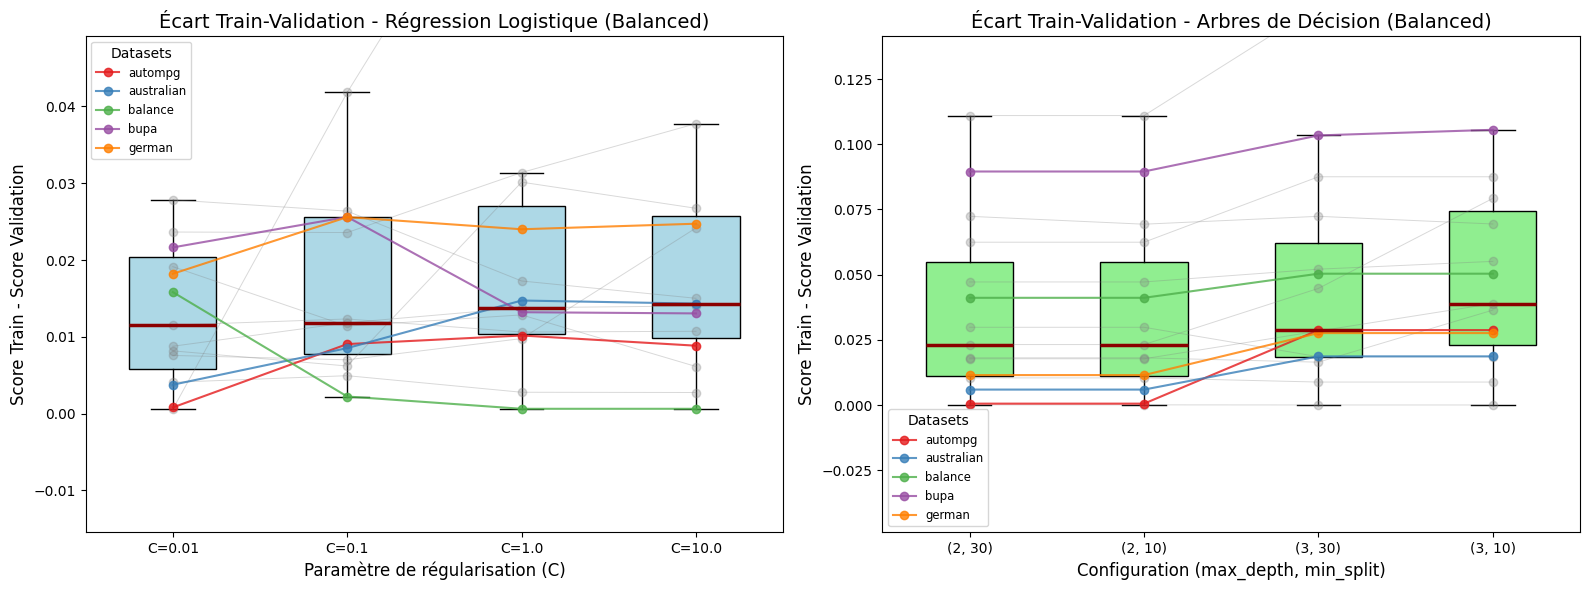

Statistiques des écarts (sans outliers):

Balanced - LR:
  C=0.01: Moy=0.012, Med=0.010, Min=0.001, Max=0.028, N=14
  C=0.1: Moy=0.015, Med=0.012, Min=0.002, Max=0.042, N=14
  C=1.0: Moy=0.015, Med=0.013, Min=0.001, Max=0.031, N=13
  C=10.0: Moy=0.015, Med=0.014, Min=0.001, Max=0.038, N=13

Balanced - DT:
  (2, 10): Moy=0.031, Med=0.021, Min=0.000, Max=0.090, N=14
  (2, 30): Moy=0.031, Med=0.021, Min=0.000, Max=0.090, N=14
  (3, 10): Moy=0.045, Med=0.038, Min=0.000, Max=0.106, N=14
  (3, 30): Moy=0.040, Med=0.029, Min=0.000, Max=0.103, N=14


In [144]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

# Charger les résultats
with open("results_merged.json", "r") as f:
    results = json.load(f)

# Hyperparamètres à analyser
lr_configs = [0.01, 0.1, 1.0, 10.0]  # C pour régression logistique
dt_configs = [(2, 30), (2, 10), (3, 30), (3, 10)]  # (max_depth, min_split) pour arbre de décision

# Listes pour stocker les données
data = []

# Traiter les données pour chaque méthode d'échantillonnage
for sampling in ["balanced", "hybridsampling"]:
    sampling_data = results.get(sampling, {})
    
    for model, model_data in sampling_data.items():
        for dataset, dataset_data in model_data.items():
            # Extraire les données d'hyperparamètres
            if "hyperparameter_results" in dataset_data:
                hyperparams = dataset_data["hyperparameter_results"]
                
                for param_key, scores in hyperparams.items():
                    if "train" not in scores or "test" not in scores:
                        continue
                    
                    # Calculer l'écart train-validation
                    train_f1 = scores["train"].get("mean_f1", 0)
                    val_f1 = scores["test"].get("mean_f1", 0)
                    gap = train_f1 - val_f1
                    
                    # Pour la régression logistique
                    if model == "Logistic Regression":
                        c_matches = re.findall(r'C_(\d+\.\d+)', param_key)
                        if c_matches:
                            c_value = float(c_matches[0])
                            if c_value in lr_configs:
                                data.append({
                                    "Model": "LR",
                                    "Config": f"C={c_value}",
                                    "Config_Value": c_value,
                                    "Config_Index": lr_configs.index(c_value),
                                    "Gap": gap,
                                    "Dataset": dataset,
                                    "Sampling": "Balanced" if sampling == "balanced" else "Hybrid"
                                })
                    
                    # Pour l'arbre de décision
                    elif model == "Decision Tree":
                        depth_matches = re.findall(r'max_depth_(\d+)', param_key)
                        min_split_matches = re.findall(r'min_samples_split_(\d+)', param_key)
                        
                        if depth_matches and min_split_matches:
                            depth = int(depth_matches[0])
                            min_split = int(min_split_matches[0])
                            
                            if (depth, min_split) in dt_configs:
                                data.append({
                                    "Model": "DT",
                                    "Config": f"({depth}, {min_split})",
                                    "Config_Value": (depth, min_split),
                                    "Config_Index": dt_configs.index((depth, min_split)),
                                    "Gap": gap,
                                    "Dataset": dataset,
                                    "Sampling": "Balanced" if sampling == "balanced" else "Hybrid"
                                })

# Convertir en DataFrame
df = pd.DataFrame(data)

# Fonction pour identifier les limites sans outliers
def get_non_outlier_limits(group):
    q1 = group['Gap'].quantile(0.25)
    q3 = group['Gap'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1*iqr
    upper = q3 + 1*iqr
    return lower, upper

# Fonction pour tracer les boxplots et les lignes de connexion
def plot_connected_points(ax, data, model_type, sampling_type, configs, config_name):
    # Filtrer les données
    filtered_data = data[(data['Model'] == model_type) & (data['Sampling'] == sampling_type)]
    
    if filtered_data.empty:
        ax.set_title(f"Pas de données pour {model_type} ({sampling_type})")
        return
    
    # Calculer les limites sans outliers pour le zoom
    limits = []
    for config in configs:
        if model_type == 'LR':
            config_data = filtered_data[filtered_data['Config_Value'] == config]
        else:  # DT
            config_data = filtered_data[filtered_data['Config_Value'] == config]
        
        if not config_data.empty:
            lower, upper = get_non_outlier_limits(config_data)
            limits.append((lower, upper))
    
    # Créer les boxplots
    if model_type == 'LR':
        config_order = [f"C={c}" for c in configs]
    else:  # DT
        config_order = [f"({d}, {s})" for d, s in configs]
    
    filtered_data['Config'] = pd.Categorical(filtered_data['Config'], categories=config_order, ordered=True)
    
    # Préparer les données pour les boxplots
    boxplot_data = []
    for c in config_order:
        subset = filtered_data[filtered_data['Config'] == c]['Gap'].values
        boxplot_data.append(subset if len(subset) > 0 else [0])
    
    # Dessiner les boxplots
    boxes = ax.boxplot(boxplot_data, positions=range(len(configs)), widths=0.5, 
                       patch_artist=True, showfliers=False)
    
    # Couleur des boxplots
    box_color = 'lightblue' if model_type == 'LR' else 'lightgreen'
    for box in boxes['boxes']:
        box.set(facecolor=box_color)

    # Personnaliser la ligne médiane (augmenter l'épaisseur et changer la couleur)
    for median in boxes['medians']:
        median.set(linewidth=2.5, color='darkred')
    
    # Sélectionner les 5 datasets à mettre en évidence
    # Compter l'occurrence de chaque dataset pour prendre les plus fréquents
    dataset_counts = filtered_data['Dataset'].value_counts()
    datasets_to_highlight = dataset_counts.head(5).index.tolist()
    
    # Palette de couleurs pour les datasets mis en évidence
    highlight_colors = plt.cm.Set1.colors[:5]
    
    # Créer une liste de handles pour la légende
    legend_handles = []
    legend_labels = []
    
    # D'abord, tracer tous les datasets en gris clair en arrière-plan
    other_datasets = [ds for ds in filtered_data['Dataset'].unique() if ds not in datasets_to_highlight]
    for dataset in other_datasets:
        dataset_data = filtered_data[filtered_data['Dataset'] == dataset].sort_values('Config_Index')
        if len(dataset_data) > 1:
            x_vals = dataset_data['Config_Index'].values
            y_vals = dataset_data['Gap'].values
            ax.plot(x_vals, y_vals, 'o-', linewidth=0.7, alpha=0.3, color='gray')
    
    # Ensuite, tracer les datasets mis en évidence
    for i, dataset in enumerate(datasets_to_highlight):
        dataset_data = filtered_data[filtered_data['Dataset'] == dataset].sort_values('Config_Index')
        if len(dataset_data) > 1:
            x_vals = dataset_data['Config_Index'].values
            y_vals = dataset_data['Gap'].values
            line = ax.plot(x_vals, y_vals, 'o-', linewidth=1.5, alpha=0.8, color=highlight_colors[i])[0]
            
            # Ajouter à la légende
            legend_handles.append(line)
            legend_labels.append(dataset)
    
    # Configurer l'axe X
    ax.set_xticks(range(len(configs)))
    ax.set_xticklabels(config_order)
    
    # Titres et labels
    model_name = "Régression Logistique" if model_type == 'LR' else "Arbres de Décision"
    ax.set_title(f'Écart Train-Validation - {model_name} ({sampling_type})', fontsize=14)
    ax.set_ylabel('Score Train - Score Validation', fontsize=12)
    ax.set_xlabel(config_name, fontsize=12)
    
    # Ajuster les limites Y pour exclure visuellement les outliers (zoom)
    if limits:
        min_y = min([lower for lower, _ in limits])
        max_y = max([upper for _, upper in limits])
        margin = (max_y - min_y) * 0.1
        ax.set_ylim(min_y - margin, max_y + margin)
    
    # Ajouter la légende pour les datasets mis en évidence
    if legend_handles:
        ax.legend(legend_handles, legend_labels, title="Datasets", loc="best", fontsize='small')

# Créer une figure 2x2
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Parcourir les combinaisons de modèles et méthodes d'échantillonnage
plot_connected_points(axes[0], df, 'LR', 'Balanced', lr_configs, 'Paramètre de régularisation (C)')
plot_connected_points(axes[1], df, 'DT', 'Balanced', dt_configs, 'Configuration (max_depth, min_split)')

# Ajuster la mise en page et enregistrer
plt.tight_layout()
plt.savefig('train_val_gap_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Afficher des statistiques récapitulatives
print("Statistiques des écarts (sans outliers):")
for model in ['LR', 'DT']:
    for sampling in ['Balanced']:
        print(f"\n{sampling} - {model}:")
        if model == 'LR':
            for c in sorted(lr_configs):
                config = f"C={c}"
                subset = df[(df['Model'] == model) & (df['Sampling'] == sampling) & (df['Config'] == config)]
                if not subset.empty:
                    # Calculer les limites sans outliers
                    q1 = subset['Gap'].quantile(0.25)
                    q3 = subset['Gap'].quantile(0.75)
                    iqr = q3 - q1
                    lower = q1 - 1*iqr
                    upper = q3 + 1*iqr
                    
                    # Filtrer pour les stats
                    non_outliers = subset[(subset['Gap'] >= lower) & (subset['Gap'] <= upper)]
                    if not non_outliers.empty:
                        gaps = non_outliers['Gap'].values
                        print(f"  {config}: Moy={np.mean(gaps):.3f}, Med={np.median(gaps):.3f}, Min={min(gaps):.3f}, Max={max(gaps):.3f}, N={len(gaps)}")
                    else:
                        print(f"  {config}: Pas de données non-outliers")
        else:  # DT
            for depth, min_split in sorted(dt_configs):
                config = f"({depth}, {min_split})"
                subset = df[(df['Model'] == model) & (df['Sampling'] == sampling) & (df['Config'] == config)]
                if not subset.empty:
                    # Calculer les limites sans outliers
                    q1 = subset['Gap'].quantile(0.25)
                    q3 = subset['Gap'].quantile(0.75)
                    iqr = q3 - q1
                    lower = q1 - 1*iqr
                    upper = q3 + 1*iqr
                    
                    # Filtrer pour les stats
                    non_outliers = subset[(subset['Gap'] >= lower) & (subset['Gap'] <= upper)]
                    if not non_outliers.empty:
                        gaps = non_outliers['Gap'].values
                        print(f"  {config}: Moy={np.mean(gaps):.3f}, Med={np.median(gaps):.3f}, Min={min(gaps):.3f}, Max={max(gaps):.3f}, N={len(gaps)}")
                    else:
                        print(f"  {config}: Pas de données non-outliers")

## Impact of hyperparameters on overfitting and underfitting for DT models

In [153]:
import json
import numpy as np
import pandas as pd
import re

# Charger les résultats
with open("results_merged.json", "r") as f:
    results = json.load(f)

# Définir les modèles à analyser
tree_models = [
    "Decision Tree",
    "AdaBoost Tree",
    "Random Forest", 
    "Gradient Boosting"
]

# Conversion pour l'affichage
model_display_names = {
    "Decision Tree": "Decision Tree",
    "AdaBoost Tree": "AdaBoost",
    "Random Forest": "Random Forest",
    "Gradient Boosting": "GradBoost"
}

# Structures pour stocker les données
tree_data = []

# Traiter seulement les données balanced
sampling = "balanced"
sampling_data = results.get(sampling, {})

print(f"Modèles disponibles dans {sampling}: {list(sampling_data.keys())}")

# Constantes pour définir l'overfitting et l'underfitting
OVERFIT_THRESHOLD = 0.15
UNDERFIT_THRESHOLD = 0.7

# Stocker les données de tous les modèles
config_params = {}
total_configs = 0

for model_name in tree_models:
    if model_name not in sampling_data:
        print(f"Modèle {model_name} non trouvé dans les données")
        continue
        
    model_data = sampling_data[model_name]
    model_display = model_display_names.get(model_name, model_name)
    print(f"Traitement du modèle: {model_name} (affiché comme {model_display})")
    
    # Parcourir tous les datasets
    for dataset, dataset_data in model_data.items():
        if "hyperparameter_results" not in dataset_data:
            continue
            
        hyperparams = dataset_data["hyperparameter_results"]
        
        for param_key in hyperparams.keys():
            # Pour le Decision Tree simple
            if model_name == "Decision Tree":
                md_match = re.search(r'max_depth_(\d+)', param_key)
                mss_match = re.search(r'min_samples_split_(\d+)', param_key)
                
                if md_match and mss_match:
                    md = int(md_match.group(1))
                    mss = int(mss_match.group(1))
                    
                    config_id = f"md={md},mss={mss}"
                    hyperparam = "N/A"  # Pas de n_estimators pour Decision Tree
                    
                    scores = hyperparams[param_key]
                    train_f1 = scores["train"]["mean_f1"]
                    val_f1 = scores["test"]["mean_f1"]
                    gap = train_f1 - val_f1
                    
                    is_overfit = gap > OVERFIT_THRESHOLD
                    is_underfit = train_f1 < UNDERFIT_THRESHOLD
                    
                    tree_data.append({
                        'Model': model_display,
                        'Dataset': dataset,
                        'Configuration': config_id,
                        'Hyperparameter': hyperparam,
                        'Train_F1': train_f1,
                        'Val_F1': val_f1,
                        'Gap': gap,
                        'Is_Overfit': is_overfit,
                        'Is_Underfit': is_underfit
                    })
                    
                    key = (config_id, hyperparam)
                    if key not in config_params:
                        config_params[key] = 1
                        total_configs += 1
            
            # Pour les méthodes d'ensemble basées sur les arbres
            else:  # AdaBoost Tree, Random Forest, Gradient Boosting
                md_match = re.search(r'max_depth_(\d+)', param_key)
                mss_match = re.search(r'min_samples_split_(\d+)', param_key)
                ne_match = re.search(r'n_estimators_(\d+)', param_key)
                
                if md_match and mss_match and ne_match:
                    md = int(md_match.group(1))
                    mss = int(mss_match.group(1))
                    ne = int(ne_match.group(1))
                    
                    config_id = f"md={md},mss={mss}"
                    hyperparam = f"n_est={ne}"
                    
                    scores = hyperparams[param_key]
                    train_f1 = scores["train"]["mean_f1"]
                    val_f1 = scores["test"]["mean_f1"]
                    gap = train_f1 - val_f1
                    
                    is_overfit = gap > OVERFIT_THRESHOLD
                    is_underfit = train_f1 < UNDERFIT_THRESHOLD
                    
                    tree_data.append({
                        'Model': model_display,
                        'Dataset': dataset,
                        'Configuration': config_id,
                        'Hyperparameter': hyperparam,
                        'Train_F1': train_f1,
                        'Val_F1': val_f1,
                        'Gap': gap,
                        'Is_Overfit': is_overfit,
                        'Is_Underfit': is_underfit
                    })
                    
                    key = (config_id, hyperparam)
                    if key not in config_params:
                        config_params[key] = 1
                        total_configs += 1

# Créer le DataFrame principal
df = pd.DataFrame(tree_data)

if df.empty:
    print("Aucune donnée extraite!")
else:
    print(f"Total: {len(df)} configurations évaluées")
    
    # Grouper par modèle, configuration et hyperparamètre pour compter le nombre de datasets
    config_stats = df.groupby(['Model', 'Configuration', 'Hyperparameter']).agg({
        'Dataset': 'nunique',
        'Is_Overfit': 'sum',
        'Is_Underfit': 'sum',
        'Train_F1': 'mean',
        'Val_F1': 'mean',
        'Gap': 'mean'
    }).reset_index()
    
    # Renommer les colonnes
    config_stats.rename(columns={
        'Dataset': 'Total_Datasets',
        'Is_Overfit': 'Overfit_Count',
        'Is_Underfit': 'Underfit_Count'
    }, inplace=True)
    
    # Calculer les pourcentages
    config_stats['Overfit_Percent'] = (config_stats['Overfit_Count'] / config_stats['Total_Datasets'] * 100).round(1)
    config_stats['Underfit_Percent'] = (config_stats['Underfit_Count'] / config_stats['Total_Datasets'] * 100).round(1)
    
    # Extraire les hyperparamètres uniques pour l'analyse individuelle
    models = df['Model'].unique()
    
    # Extraire tous les hyperparamètres uniques
    all_md_values = set()
    all_mss_values = set()
    all_n_est_values = set()
    
    for _, row in config_stats.iterrows():
        config = row['Configuration']
        param = row['Hyperparameter']
        
        md_match = re.search(r'md=(\d+)', config)
        mss_match = re.search(r'mss=(\d+)', config)
        ne_match = re.search(r'n_est=(\d+)', param)
        
        if md_match:
            all_md_values.add(int(md_match.group(1)))
        if mss_match:
            all_mss_values.add(int(mss_match.group(1)))
        if ne_match:
            all_n_est_values.add(int(ne_match.group(1)))
    
    # Trier les hyperparamètres
    all_md_values = sorted(all_md_values)
    all_mss_values = sorted(all_mss_values)
    all_n_est_values = sorted(all_n_est_values)
    
    # Créer les listes d'hyperparamètres
    hyperparams = []
    
    # Ajouter les valeurs de max_depth
    for md in all_md_values:
        hyperparams.append(f"max_depth={md}")
    
    # Ajouter les valeurs de min_samples_split
    for mss in all_mss_values:
        hyperparams.append(f"min_samples_split={mss}")
    
    # Ajouter les valeurs de n_estimators
    for n_est in all_n_est_values:
        hyperparams.append(f"n_estimators={n_est}")
    
    # Créer des DataFrames vides pour l'overfitting et l'underfitting
    overfit_df = pd.DataFrame(index=hyperparams, columns=models)
    underfit_df = pd.DataFrame(index=hyperparams, columns=models)
    
    # Remplir les DataFrames
    for model in models:
        model_data = config_stats[config_stats['Model'] == model]
        
        # Initialiser les compteurs
        md_overfit = {md: [] for md in all_md_values}
        mss_overfit = {mss: [] for mss in all_mss_values}
        n_est_overfit = {ne: [] for ne in all_n_est_values}
        
        md_underfit = {md: [] for md in all_md_values}
        mss_underfit = {mss: [] for mss in all_mss_values}
        n_est_underfit = {ne: [] for ne in all_n_est_values}
        
        # Collecter les pourcentages
        for _, row in model_data.iterrows():
            config = row['Configuration']
            param = row['Hyperparameter']
            
            md_match = re.search(r'md=(\d+)', config)
            mss_match = re.search(r'mss=(\d+)', config)
            ne_match = re.search(r'n_est=(\d+)', param)
            
            # Ajouter les pourcentages pour max_depth et min_samples_split
            if md_match and mss_match:
                md = int(md_match.group(1))
                mss = int(mss_match.group(1))
                
                md_overfit[md].append(row['Overfit_Percent'])
                mss_overfit[mss].append(row['Overfit_Percent'])
                
                md_underfit[md].append(row['Underfit_Percent'])
                mss_underfit[mss].append(row['Underfit_Percent'])
            
            # Ajouter les pourcentages pour n_estimators (uniquement pour les ensembles)
            if ne_match:
                ne = int(ne_match.group(1))
                n_est_overfit[ne].append(row['Overfit_Percent'])
                n_est_underfit[ne].append(row['Underfit_Percent'])
        
        # Remplir les DataFrames avec les moyennes
        # Pour max_depth
        for md in all_md_values:
            if md_overfit[md]:
                overfit_df.loc[f"max_depth={md}", model] = np.mean(md_overfit[md])
                underfit_df.loc[f"max_depth={md}", model] = np.mean(md_underfit[md])
        
        # Pour min_samples_split
        for mss in all_mss_values:
            if mss_overfit[mss]:
                overfit_df.loc[f"min_samples_split={mss}", model] = np.mean(mss_overfit[mss])
                underfit_df.loc[f"min_samples_split={mss}", model] = np.mean(mss_underfit[mss])
        
        # Pour n_estimators
        for ne in all_n_est_values:
            if n_est_overfit[ne]:
                overfit_df.loc[f"n_estimators={ne}", model] = np.mean(n_est_overfit[ne])
                underfit_df.loc[f"n_estimators={ne}", model] = np.mean(n_est_underfit[ne])
    
    # Afficher les tableaux avec formatage
    print("\n=== POURCENTAGE MOYEN D'OVERFITTING PAR HYPERPARAMÈTRE ===")
    print(overfit_df.fillna("—").applymap(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x))
    
    print("\n=== POURCENTAGE MOYEN D'UNDERFITTING PAR HYPERPARAMÈTRE ===")
    print(underfit_df.fillna("—").applymap(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x))

Modèles disponibles dans balanced: ['Stacking', 'Logistic Regression', 'Bagging LR', 'AdaBoost LR', 'Decision Tree', 'Random Forest', 'AdaBoost Tree', 'Gradient Boosting']
Traitement du modèle: Decision Tree (affiché comme Decision Tree)
Traitement du modèle: AdaBoost Tree (affiché comme AdaBoost)
Traitement du modèle: Random Forest (affiché comme Random Forest)
Traitement du modèle: Gradient Boosting (affiché comme GradBoost)
Total: 600 configurations évaluées

=== POURCENTAGE MOYEN D'OVERFITTING PAR HYPERPARAMÈTRE ===
                     Decision Tree AdaBoost Random Forest GradBoost
max_depth=2                   0.0%    10.0%          0.0%     16.7%
max_depth=3                   6.7%    17.8%          4.5%     30.0%
min_samples_split=10          3.4%    12.2%          3.4%     24.4%
min_samples_split=30          3.4%    15.5%          1.1%     22.2%
n_estimators=50                  —    16.7%          1.7%     13.3%
n_estimators=100                 —    13.3%          1.7%     26.6

C:\Users\levovo pro p50\AppData\Local\Temp\ipykernel_18712\1888488059.py:272: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(overfit_df.fillna("—").applymap(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x))
C:\Users\levovo pro p50\AppData\Local\Temp\ipykernel_18712\1888488059.py:272: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(overfit_df.fillna("—").applymap(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x))
C:\Users\levovo pro p50\AppData\Local\Temp\ipykernel_18712\1888488059.py:275: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.se

In [168]:
import json
import numpy as np
import pandas as pd
import re

# Charger les résultats
with open("results_merged.json", "r") as f:
    results = json.load(f)

# Définir les modèles à analyser
lr_models = [
    "Logistic Regression",
    "Bagging LR",
    "AdaBoost LR"
]

# Conversion pour l'affichage
model_display_names = {
    "Logistic Regression": "LR",
    "Bagging LR": "Bagging LR",
    "AdaBoost LR": "AdaBoost LR"
}

# Structures pour stocker les données
lr_data = []

# Traiter seulement les données balanced
sampling = "balanced"
sampling_data = results.get(sampling, {})

print(f"Modèles disponibles dans {sampling}: {list(sampling_data.keys())}")

# Constantes pour définir l'overfitting et l'underfitting
OVERFIT_THRESHOLD = 0.15
UNDERFIT_THRESHOLD = 0.7

# Stocker les données de tous les modèles
config_params = {}
total_configs = 0

for model_name in lr_models:
    if model_name not in sampling_data:
        print(f"Modèle {model_name} non trouvé dans les données")
        continue
        
    model_data = sampling_data[model_name]
    model_display = model_display_names.get(model_name, model_name)
    print(f"Traitement du modèle: {model_name} (affiché comme {model_display})")
    
    # Parcourir tous les datasets
    for dataset, dataset_data in model_data.items():
        if "hyperparameter_results" not in dataset_data:
            continue
            
        hyperparams = dataset_data["hyperparameter_results"]
        
        for param_key in hyperparams.keys():
            # Pour Logistic Regression simple
            if model_name == "Logistic Regression":
                c_match = re.search(r'C_([0-9.]+)', param_key)
                
                if c_match:
                    c_value = float(c_match.group(1))
                    
                    config_id = f"C={c_value}"
                    hyperparam = "N/A"  # Pas de n_estimators pour LogReg
                    
                    scores = hyperparams[param_key]
                    train_f1 = scores["train"]["mean_f1"]
                    val_f1 = scores["test"]["mean_f1"]
                    gap = train_f1 - val_f1
                    
                    is_overfit = gap > OVERFIT_THRESHOLD
                    is_underfit = train_f1 < UNDERFIT_THRESHOLD
                    
                    lr_data.append({
                        'Model': model_display,
                        'Dataset': dataset,
                        'Configuration': config_id,
                        'Hyperparameter': hyperparam,
                        'Train_F1': train_f1,
                        'Val_F1': val_f1,
                        'Gap': gap,
                        'Is_Overfit': is_overfit,
                        'Is_Underfit': is_underfit
                    })
                    
                    key = (config_id, hyperparam)
                    if key not in config_params:
                        config_params[key] = 1
                        total_configs += 1
            
            # Pour les méthodes d'ensemble basées sur LR
            else:  # Bagging LR, AdaBoost LR
                c_match = re.search(r'C_([0-9.]+)', param_key)
                ne_match = re.search(r'n_estimators_(\d+)', param_key)
                
                if c_match and ne_match:
                    c_value = float(c_match.group(1))
                    ne = int(ne_match.group(1))
                    
                    config_id = f"C={c_value}"
                    hyperparam = f"n_est={ne}"
                    
                    scores = hyperparams[param_key]
                    train_f1 = scores["train"]["mean_f1"]
                    val_f1 = scores["test"]["mean_f1"]
                    gap = train_f1 - val_f1
                    
                    is_overfit = gap > OVERFIT_THRESHOLD
                    is_underfit = train_f1 < UNDERFIT_THRESHOLD
                    
                    lr_data.append({
                        'Model': model_display,
                        'Dataset': dataset,
                        'Configuration': config_id,
                        'Hyperparameter': hyperparam,
                        'Train_F1': train_f1,
                        'Val_F1': val_f1,
                        'Gap': gap,
                        'Is_Overfit': is_overfit,
                        'Is_Underfit': is_underfit
                    })
                    
                    key = (config_id, hyperparam)
                    if key not in config_params:
                        config_params[key] = 1
                        total_configs += 1

# Créer le DataFrame principal
df = pd.DataFrame(lr_data)

if df.empty:
    print("Aucune donnée extraite!")
else:
    print(f"Total: {len(df)} configurations évaluées")
    
    # Grouper par modèle, configuration et hyperparamètre pour compter le nombre de datasets
    config_stats = df.groupby(['Model', 'Configuration', 'Hyperparameter']).agg({
        'Dataset': 'nunique',
        'Is_Overfit': 'sum',
        'Is_Underfit': 'sum',
        'Train_F1': 'mean',
        'Val_F1': 'mean',
        'Gap': 'mean'
    }).reset_index()
    
    # Utiliser les noms des colonnes existants - pas besoin de renommer
    config_stats['Overfit_Percent'] = (config_stats['Is_Overfit'] / config_stats['Dataset'] * 100).round(1)
    config_stats['Underfit_Percent'] = (config_stats['Is_Underfit'] / config_stats['Dataset'] * 100).round(1)
    
    # Extraire les hyperparamètres uniques pour l'analyse individuelle
    models = df['Model'].unique()
    
    # Extraire tous les hyperparamètres uniques
    all_c_values = set()
    all_n_est_values = set()
    
    for _, row in config_stats.iterrows():
        config = row['Configuration']
        param = row['Hyperparameter']
        
        c_match = re.search(r'C=([0-9.]+)', config)
        ne_match = re.search(r'n_est=(\d+)', param)
        
        if c_match:
            all_c_values.add(float(c_match.group(1)))
        if ne_match:
            all_n_est_values.add(int(ne_match.group(1)))
    
    # Trier les hyperparamètres
    all_c_values = sorted(all_c_values)
    all_n_est_values = sorted(all_n_est_values)
    
    # Créer les listes d'hyperparamètres
    hyperparams = []
    
    # Ajouter les valeurs de C
    for c in all_c_values:
        hyperparams.append(f"C={c}")
    
    # Ajouter les valeurs de n_estimators
    for n_est in all_n_est_values:
        hyperparams.append(f"n_estimators={n_est}")
    
    # Créer des DataFrames vides pour l'overfitting et l'underfitting
    overfit_df = pd.DataFrame(index=hyperparams, columns=models)
    underfit_df = pd.DataFrame(index=hyperparams, columns=models)
    
    # Remplir les DataFrames
    for model in models:
        model_data = config_stats[config_stats['Model'] == model]
        
        # Initialiser les compteurs
        c_overfit = {c: [] for c in all_c_values}
        n_est_overfit = {ne: [] for ne in all_n_est_values}
        
        c_underfit = {c: [] for c in all_c_values}
        n_est_underfit = {ne: [] for ne in all_n_est_values}
        
        # Collecter les pourcentages
        for _, row in model_data.iterrows():
            config = row['Configuration']
            param = row['Hyperparameter']
            
            c_match = re.search(r'C=([0-9.]+)', config)
            ne_match = re.search(r'n_est=(\d+)', param)
            
            # Ajouter les pourcentages pour C
            if c_match:
                c = float(c_match.group(1))
                c_overfit[c].append(row['Overfit_Percent'])
                c_underfit[c].append(row['Underfit_Percent'])
            
            # Ajouter les pourcentages pour n_estimators (uniquement pour les ensembles)
            if ne_match:
                ne = int(ne_match.group(1))
                n_est_overfit[ne].append(row['Overfit_Percent'])
                n_est_underfit[ne].append(row['Underfit_Percent'])
        
        # Remplir les DataFrames avec les moyennes
        # Pour C
        for c in all_c_values:
            if c_overfit[c]:
                overfit_df.loc[f"C={c}", model] = np.mean(c_overfit[c])
                underfit_df.loc[f"C={c}", model] = np.mean(c_underfit[c])
        
        # Pour n_estimators
        for ne in all_n_est_values:
            if n_est_overfit[ne]:
                overfit_df.loc[f"n_estimators={ne}", model] = np.mean(n_est_overfit[ne])
                underfit_df.loc[f"n_estimators={ne}", model] = np.mean(n_est_underfit[ne])
    
    # Afficher les tableaux avec formatage
    print("\n=== POURCENTAGE MOYEN D'OVERFITTING PAR HYPERPARAMÈTRE ===")
    print(overfit_df.fillna("—").applymap(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x))
    
    print("\n=== POURCENTAGE MOYEN D'UNDERFITTING PAR HYPERPARAMÈTRE ===")
    print(underfit_df.fillna("—").applymap(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x))

Modèles disponibles dans balanced: ['Stacking', 'Logistic Regression', 'Bagging LR', 'AdaBoost LR', 'Decision Tree', 'Random Forest', 'AdaBoost Tree', 'Gradient Boosting']
Traitement du modèle: Logistic Regression (affiché comme LR)
Traitement du modèle: Bagging LR (affiché comme Bagging LR)
Traitement du modèle: AdaBoost LR (affiché comme AdaBoost LR)
Total: 420 configurations évaluées

=== POURCENTAGE MOYEN D'OVERFITTING PAR HYPERPARAMÈTRE ===
                    LR Bagging LR AdaBoost LR
C=0.01            0.0%       0.0%        0.0%
C=0.1             0.0%       0.0%        0.0%
C=1.0             0.0%       6.7%        0.0%
C=10.0            6.7%       6.7%        6.7%
n_estimators=50      —       3.4%        1.7%
n_estimators=100     —       3.4%        1.7%
n_estimators=150     —       3.4%        1.7%

=== POURCENTAGE MOYEN D'UNDERFITTING PAR HYPERPARAMÈTRE ===
                     LR Bagging LR AdaBoost LR
C=0.01            13.3%      13.3%       13.3%
C=0.1              6.7%    

C:\Users\levovo pro p50\AppData\Local\Temp\ipykernel_18712\3823753401.py:236: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print(overfit_df.fillna("—").applymap(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x))
C:\Users\levovo pro p50\AppData\Local\Temp\ipykernel_18712\3823753401.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(overfit_df.fillna("—").applymap(lambda x: f"{x:.1f}%" if isinstance(x, (int, float)) else x))
C:\Users\levovo pro p50\AppData\Local\Temp\ipykernel_18712\3823753401.py:239: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.se

Models used: ['LR', 'Bagging LR', 'AdaBoost LR']


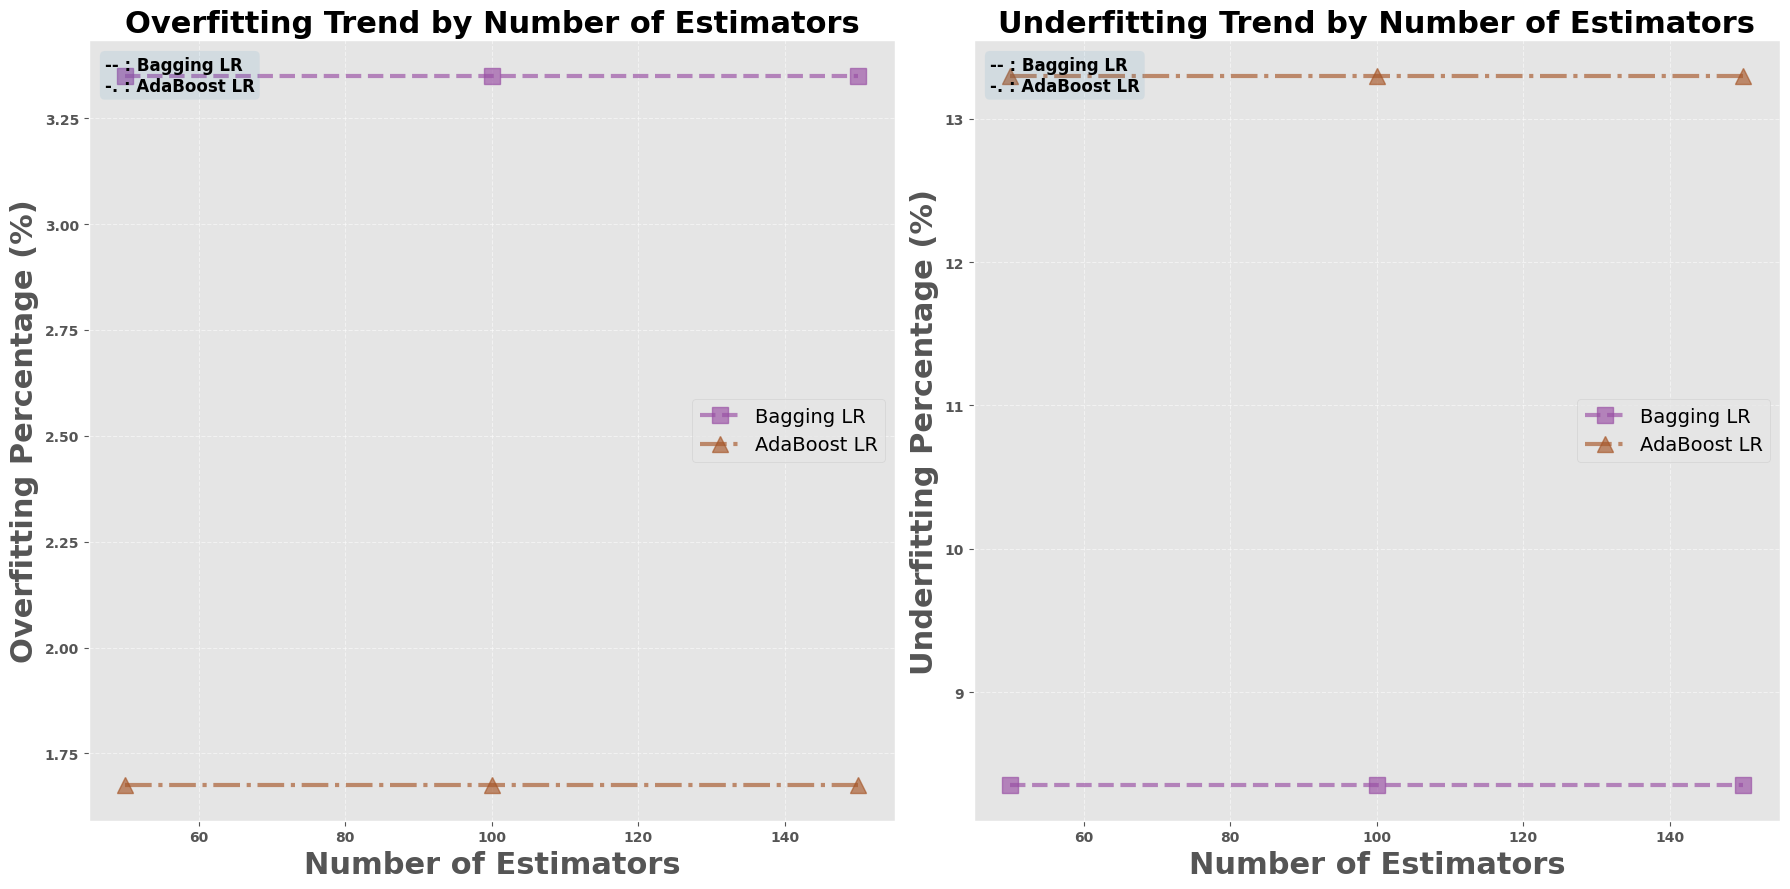

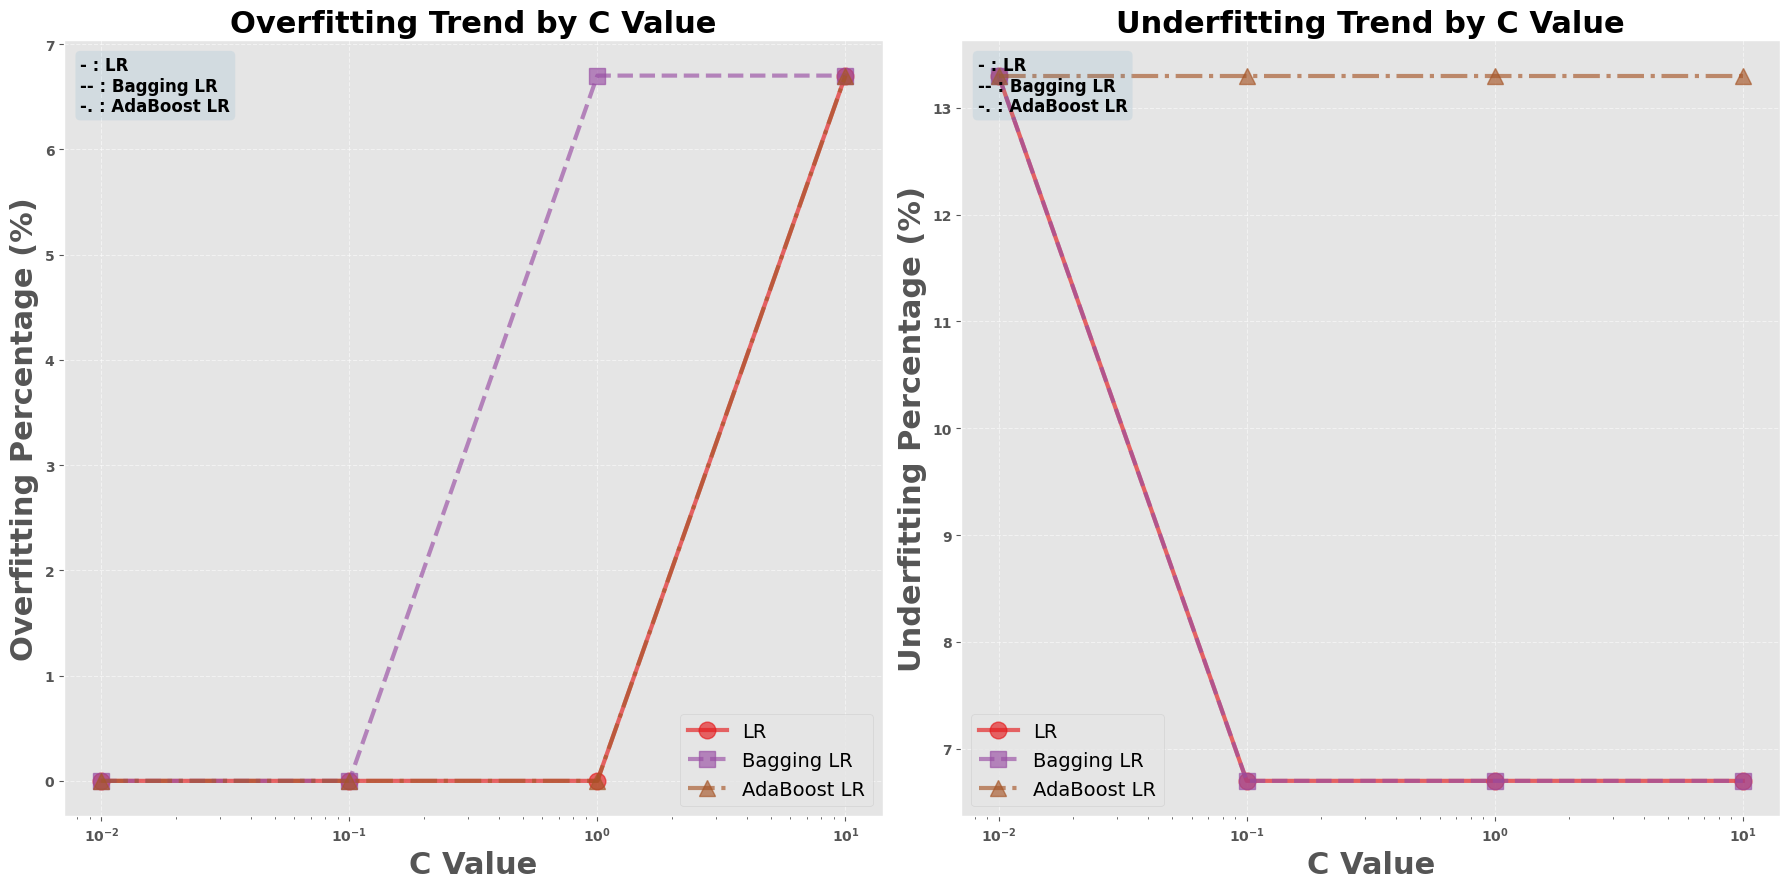

<Figure size 1400x900 with 0 Axes>

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Font size parameters for easy adjustment
TITLE_SIZE = 22      # Size for titles
LABEL_SIZE = 22      # Size for axis labels
TICK_SIZE = 13       # Size for tick labels
LEGEND_SIZE = 14     # Size for legend text
ANNOT_SIZE = 12      # Size for annotations

# Configurations for better readability
plt.rcParams['figure.figsize'] = (14, 9)  # Larger figure
plt.rcParams['font.size'] = TICK_SIZE
plt.style.use('ggplot')

# Define alpha and colormap
ALPHA = 0.65
COLOR_MAP = plt.cm.Set1

def create_lr_line_charts(overfit_df, underfit_df):
    # Separate hyperparameters by type
    c_params = [idx for idx in overfit_df.index if str(idx).startswith('C=')]
    n_est_params = [idx for idx in overfit_df.index if str(idx).startswith('n_estimators=')]
    
    figs = []
    
    # Use column names directly
    lr_models = overfit_df.columns.tolist()
    print(f"Models used: {lr_models}")
    
    # Determine ensemble models (all except LR)
    ensemble_models = [m for m in lr_models if m != 'LR']
    
    # Define different line styles and markers for each model
    line_styles = {
        'LR': '-',            # solid line
        'Bagging LR': '--',   # dashed line
        'AdaBoost LR': '-.'   # dashdot line
    }
    
    markers = {
        'LR': 'o',            # circle
        'Bagging LR': 's',    # square
        'AdaBoost LR': '^'    # triangle
    }
    
    # Create a color palette for our models
    colors = {model: COLOR_MAP(i/len(lr_models)) for i, model in enumerate(lr_models)}
    
    # Function to extract values handling exceptions
    def extract_values(df, params, model):
        values = []
        for param in params:
            try:
                val = df.loc[param, model]
                # Convert to string and handle special cases
                val_str = str(val)
                if val_str == '—' or val_str == 'nan' or val_str == '' or pd.isna(val):
                    values.append(np.nan)
                else:
                    # Remove % symbol if present
                    val_str = val_str.replace('%', '')
                    values.append(float(val_str))
            except (KeyError, ValueError, TypeError):
                values.append(np.nan)
        return values
    
    # Graph of trends for parameter C
    if c_params:
        fig, axes = plt.subplots(1, 2, figsize=(18, 9))
        
        # Convert labels to numeric values for plotting
        c_values = [float(c.replace('C=', '')) for c in c_params]
        
        # Graph for overfitting
        for model in lr_models:
            values = extract_values(overfit_df, c_params, model)
            
            if not all(np.isnan(values)):
                axes[0].plot(c_values, values, 
                           marker=markers[model], 
                           linestyle=line_styles[model], 
                           label=model, 
                           color=colors[model], 
                           linewidth=3,    # Thicker
                           markersize=12,  # Larger
                           alpha=ALPHA)
        
        axes[0].set_xlabel('C Value', fontsize=LABEL_SIZE, fontweight='bold')
        axes[0].set_ylabel('Overfitting Percentage (%)', fontsize=LABEL_SIZE, fontweight='bold')
        axes[0].set_title('Overfitting Trend by C Value', fontsize=TITLE_SIZE, fontweight='bold')
        if min([v for v in c_values if v > 0], default=1) < max(c_values, default=10):
            axes[0].set_xscale('log')
        axes[0].grid(True, linestyle='--', alpha=0.5)
        axes[0].legend(fontsize=LEGEND_SIZE, loc='best', framealpha=0.7)
        
        # Add text annotation for line styles
        axes[0].annotate('- : LR\n-- : Bagging LR\n-. : AdaBoost LR', 
                       xy=(0.02, 0.98), xycoords='axes fraction',
                       ha='left', va='top',
                       fontsize=ANNOT_SIZE, fontweight='bold', 
                       bbox=dict(boxstyle='round', alpha=0.1))
        
        # Make tick labels bold
        for tick in axes[0].get_xticklabels() + axes[0].get_yticklabels():
            tick.set_fontweight('bold')
        
        # Graph for underfitting
        for model in lr_models:
            values = extract_values(underfit_df, c_params, model)
            
            if not all(np.isnan(values)):
                axes[1].plot(c_values, values, 
                           marker=markers[model], 
                           linestyle=line_styles[model], 
                           label=model, 
                           color=colors[model],
                           linewidth=3,
                           markersize=12,
                           alpha=ALPHA)
        
        axes[1].set_xlabel('C Value', fontsize=LABEL_SIZE, fontweight='bold')
        axes[1].set_ylabel('Underfitting Percentage (%)', fontsize=LABEL_SIZE, fontweight='bold')
        axes[1].set_title('Underfitting Trend by C Value', fontsize=TITLE_SIZE, fontweight='bold')
        if min([v for v in c_values if v > 0], default=1) < max(c_values, default=10):
            axes[1].set_xscale('log')
        axes[1].grid(True, linestyle='--', alpha=0.5)
        axes[1].legend(fontsize=LEGEND_SIZE, loc='best', framealpha=0.7)
        
        # Add text annotation for line styles
        axes[1].annotate('- : LR\n-- : Bagging LR\n-. : AdaBoost LR', 
                       xy=(0.02, 0.98), xycoords='axes fraction',
                       ha='left', va='top',
                       fontsize=ANNOT_SIZE, fontweight='bold', 
                       bbox=dict(boxstyle='round', alpha=0.1))
        
        # Make tick labels bold
        for tick in axes[1].get_xticklabels() + axes[1].get_yticklabels():
            tick.set_fontweight('bold')
        
        plt.tight_layout()
        figs.append(fig)
    
    # Graph of trends for number of estimators
    if n_est_params:
        fig, axes = plt.subplots(1, 2, figsize=(18, 9))
        
        # Convert labels to numeric values
        n_est_values = [int(ne.replace('n_estimators=', '')) for ne in n_est_params]
        
        # Graph for overfitting (only for ensemble models)
        for model in ensemble_models:
            values = extract_values(overfit_df, n_est_params, model)
            
            if not all(np.isnan(values)):
                axes[0].plot(n_est_values, values, 
                           marker=markers[model], 
                           linestyle=line_styles[model], 
                           label=model, 
                           color=colors[model],
                           linewidth=3,
                           markersize=12,
                           alpha=ALPHA)
        
        axes[0].set_xlabel('Number of Estimators', fontsize=LABEL_SIZE, fontweight='bold')
        axes[0].set_ylabel('Overfitting Percentage (%)', fontsize=LABEL_SIZE, fontweight='bold')
        axes[0].set_title('Overfitting Trend by Number of Estimators', fontsize=TITLE_SIZE, fontweight='bold')
        axes[0].grid(True, linestyle='--', alpha=0.5)
        axes[0].legend(fontsize=LEGEND_SIZE, loc='best', framealpha=0.7)
        
        # Add text annotation for line styles
        axes[0].annotate('-- : Bagging LR\n-. : AdaBoost LR', 
                       xy=(0.02, 0.98), xycoords='axes fraction',
                       ha='left', va='top',
                       fontsize=ANNOT_SIZE, fontweight='bold', 
                       bbox=dict(boxstyle='round', alpha=0.1))
        
        # Make tick labels bold
        for tick in axes[0].get_xticklabels() + axes[0].get_yticklabels():
            tick.set_fontweight('bold')
        
        # Graph for underfitting (only for ensemble models)
        for model in ensemble_models:
            values = extract_values(underfit_df, n_est_params, model)
            
            if not all(np.isnan(values)):
                axes[1].plot(n_est_values, values, 
                           marker=markers[model], 
                           linestyle=line_styles[model], 
                           label=model, 
                           color=colors[model],
                           linewidth=3,
                           markersize=12,
                           alpha=ALPHA)
        
        axes[1].set_xlabel('Number of Estimators', fontsize=LABEL_SIZE, fontweight='bold')
        axes[1].set_ylabel('Underfitting Percentage (%)', fontsize=LABEL_SIZE, fontweight='bold')
        axes[1].set_title('Underfitting Trend by Number of Estimators', fontsize=TITLE_SIZE, fontweight='bold')
        axes[1].grid(True, linestyle='--', alpha=0.5)
        axes[1].legend(fontsize=LEGEND_SIZE, loc='best', framealpha=0.7)
        
        # Add text annotation for line styles
        axes[1].annotate('-- : Bagging LR\n-. : AdaBoost LR', 
                       xy=(0.02, 0.98), xycoords='axes fraction',
                       ha='left', va='top',
                       fontsize=ANNOT_SIZE, fontweight='bold', 
                       bbox=dict(boxstyle='round', alpha=0.1))
        
        # Make tick labels bold
        for tick in axes[1].get_xticklabels() + axes[1].get_yticklabels():
            tick.set_fontweight('bold')
        
        plt.tight_layout()
        figs.append(fig)
    
    return figs

# Using the function
line_figs = create_lr_line_charts(overfit_df, underfit_df)

# For each generated figure
for i, fig in enumerate(line_figs):
    plt.figure(fig.number)
    plt.savefig(f'trend_lr_models_{i}.png', dpi=300, bbox_inches='tight')
    plt.show()